In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvisionfrom torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Custom Dataset Transform

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/winnie/food-pics/inference'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [54]:
import glob
class customDataset(datasets.VisionDataset):
    
    def __init__(self,root,transform,loader):
        self.root = root
        self.transform = transform
        self.image_list = glob.glob(root+"/*.jpg")
        self.loader = loader
        
    def __getitem__(self,idx):
        #print(idx)
        path = self.image_list[idx]
        #print(path)
        sample = self.loader(path)
        sample = self.transform(sample)
        return {'imdix':idx,'path':path,'image':sample}
        
    def __len__(self):
        return len(self.image_list)


In [55]:
from PIL import Image
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


In [56]:
test_set = customDataset(data_dir,data_transforms['val'],pil_loader)
custom_batch_size = 8
dataloader = torch.utils.data.DataLoader(test_set, batch_size=custom_batch_size,\
                                         shuffle=False, num_workers=4)
print(len(test_set))

101000


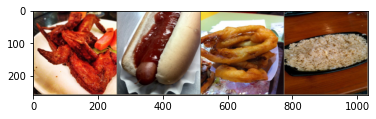

In [57]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
outputs = next(iter(dataloader))
inputs = outputs["image"]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Load Model

In [60]:
!ls

'Annotating Image Data.ipynb'	 'Retrain resnet for classifying plates.ipynb'
'Inference Pipeline.ipynb'	 'Splitting Train and Val.ipynb'
 plate-classification-model.pth   Untitled.ipynb


In [61]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_weights = "./plate-classification-model.pth"
model_conv.load_state_dict(torch.load(model_weights))
model_conv.eval()
model_conv = model_conv.to(device)


In [81]:
class_names = ["non-plate","plate"]

In [82]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs = data['image']
            paths = data['path']
            imidx = data['imdix']
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

tensor([[ 0.8981, -0.8216],
        [ 0.1307, -0.1312],
        [-0.2182, -1.1360],
        [-0.8604, -0.8144]], device='cuda:0')


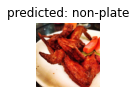

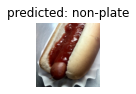

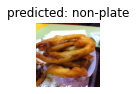

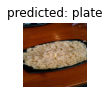

tensor([[-0.2665, -0.6027],
        [-1.2013, -0.0942],
        [ 0.6525, -0.7096],
        [ 1.6483, -0.7363]], device='cuda:0')


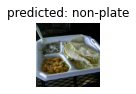

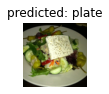

In [83]:
visualize_model(model_conv, num_images=6)

In [116]:
import pandas as pd
df = pd.DataFrame({'data_path':[None]*101000,'plate_prob':[None]*101000,'no_plate_prob':[None]*101000})
df


,data_path,plate_prob,no_plate_prob
0,None,None,None
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None
...,...,...,...
100995,None,None,None
100996,None,None,None
100997,None,None,None
100998,None,None,None


In [ ]:
with torch.no_grad():
    for i, data in enumerate(dataloader):
        inputs = data['image']
        paths = data['path']
        imidx = data['imdix'].numpy()
        inputs = inputs.to(device)

        outputs = model_conv(inputs)
        m = nn.Softmax(dim=1)
        pred = m(outputs)
        pred = pred.cpu().numpy()
        for j in range(inputs.size()[0]):
            cur_path = paths[j]
            cur_im_idx = imidx[j]
            no_plate_prob = pred[j,0]
            plate_prob = pred[j,1]
            
            #print(cur_im_idx, plate_prob, no_plate_prob)
            df.loc[cur_im_idx,'path'] = cur_path
            df.loc[cur_im_idx,'no_plate_prob'] = no_plate_prob
            df.loc[cur_im_idx,'plate_prob'] = plate_prob
            
            #print(cur_im_idx)
df.to_csv('inference_results.csv')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff09c5a7940>
Traceback (most recent call last):
  File "/home/winnie/miniconda3/envs/hippo/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/winnie/miniconda3/envs/hippo/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/winnie/miniconda3/envs/hippo/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff09c5a7940>
Traceback (most recent call last):
  File "/home/winnie/miniconda3/envs/hippo/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/winnie/miniconda3/envs/hippo/lib/python

In [131]:
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Frequency'>

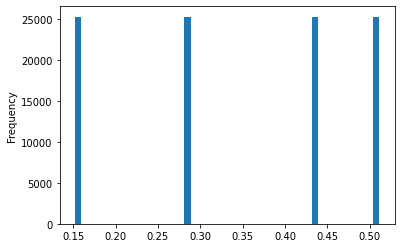

In [132]:
df.head()
df.plate_prob.plot.hist(bins=50)

In [133]:
df.plate_prob.describe()

count     101000.000000
unique         4.000000
top            0.151898
freq       25250.000000
Name: plate_prob, dtype: float64